# DenseNet

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer. No class or sample specific weights are used. Same as cnn-kaggle-v021

This notebook is set up for cross-validation, which is freq. used in research

# Changeable Parameters

_____________________________________________________________________

In [1]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size
batch_size = 20000

# Number of epochs
epoch_t = 40

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# number of folds
n_folds = 10

_____________________________________________________________________

In [2]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras import datasets, layers, models, losses, Model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [4]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [6]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/learning_curve"
    for files in os.listdir(dir):
        if "densenet" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: crossv-densenet{batch_size}-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/learning_curve/crossv-densenet{batch_size}-local-v{new_vnum:03}"
    os.makedirs(new_dir)

6 matches(es) found
--------------
New folder name: crossv-densenet20000-local-v007
--------------


**Data**


In [7]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"

Load the data. No data augmentation takes place

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


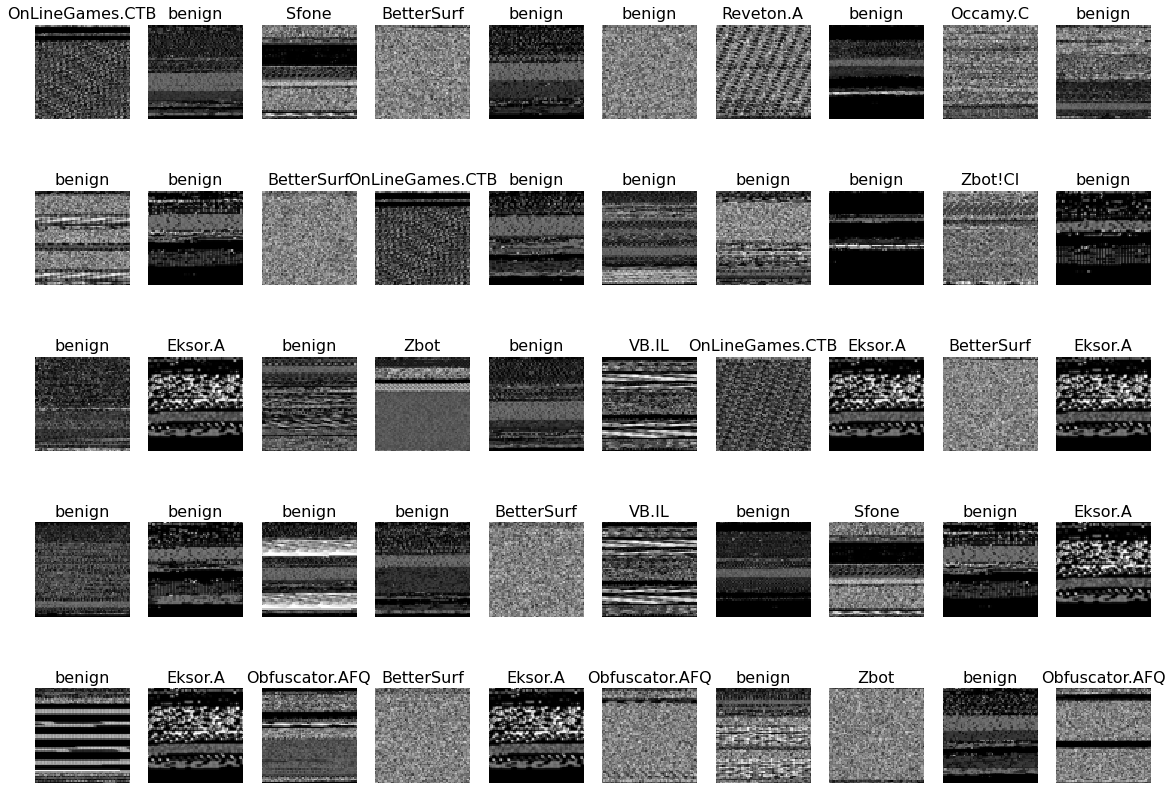

In [9]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [10]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()
x_axis = np.arange(len(list(classes)))

Plot data distribution among all classes

Standardize images

In [11]:
imgs = tf.keras.applications.densenet.preprocess_input(imgs)

Plot data distribution among train, val. and test set

# DenseNet
We will now build our **DenseNet169** model using Tensorflow/Keras. This model will have the following layers :

**Input shape** : 64 * 64 * 3

Nota bene that the DenseNet only takes RGB images (with 3 channels)

In [12]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold

In [13]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

We want **11** classes

In [14]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  11


In [15]:
def confusion_matrix(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names_bin, columns=class_names_bin, 
        )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

class_names_bin= ("ransomware", "benign")

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [16]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [17]:
# Performance metrics
multi_acc_per_fold = []
loss_per_fold = []
multi_f1_per_fold = []
bin_acc_per_fold = []
bin_tpr_per_fold = []
bin_f1_per_fold = []
bin_mcc_per_fold = []

tp = []
fp = []
fn = []
tn = []

# Predictions
y_pred = []
y_true = []

# History
history = []

# Data distribution
train_distr = []
test_distr= []

rw_count = []
bn_count = []

In [18]:
kfold = KFold(n_splits=n_folds, shuffle=True)

Epoch 1/40
563/563 [==============================] - 88s 128ms/step - loss: 0.4384 - accuracy: 0.8847 - val_loss: 0.2456 - val_accuracy: 0.9300

Epoch 00001: val_loss improved from inf to 0.24563, saving model to /Users/Max/Documents/GitHub/learning_curve/crossv-densenet20000-local-v007\model.h5
Epoch 2/40
563/563 [==============================] - 67s 118ms/step - loss: 0.2382 - accuracy: 0.9303 - val_loss: 0.1687 - val_accuracy: 0.9455

Epoch 00002: val_loss improved from 0.24563 to 0.16875, saving model to /Users/Max/Documents/GitHub/learning_curve/crossv-densenet20000-local-v007\model.h5
Epoch 3/40
563/563 [==============================] - 65s 116ms/step - loss: 0.2433 - accuracy: 0.9302 - val_loss: 0.6537 - val_accuracy: 0.7580

Epoch 00003: val_loss did not improve from 0.16875
Epoch 4/40
563/563 [==============================] - 66s 117ms/step - loss: 0.3253 - accuracy: 0.9124 - val_loss: 0.2272 - val_accuracy: 0.9310

Epoch 00004: val_loss did not improve from 0.16875
Epoch 


Epoch 00037: val_loss did not improve from 0.12961
Epoch 38/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0412 - accuracy: 0.9856 - val_loss: 0.1784 - val_accuracy: 0.9705

Epoch 00038: val_loss did not improve from 0.12961
Epoch 39/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0407 - accuracy: 0.9861 - val_loss: 0.1673 - val_accuracy: 0.9725

Epoch 00039: val_loss did not improve from 0.12961
Epoch 40/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0408 - accuracy: 0.9862 - val_loss: 0.1862 - val_accuracy: 0.9730

Epoch 00040: val_loss did not improve from 0.12961
Score for fold 1: loss of 0.18617752194404602; accuracy of 97.29999899864197%
Epoch 1/40
563/563 [==============================] - 78s 118ms/step - loss: 0.5898 - accuracy: 0.8763 - val_loss: 25331902.0000 - val_accuracy: 0.0590

Epoch 00001: val_loss did not improve from 0.12961
Epoch 2/40
563/563 [==============================] - 64s 114ms/step - l


Epoch 00037: val_loss did not improve from 0.12961
Epoch 38/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0342 - accuracy: 0.9884 - val_loss: 0.2086 - val_accuracy: 0.9595

Epoch 00038: val_loss did not improve from 0.12961
Epoch 39/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0331 - accuracy: 0.9883 - val_loss: 0.2202 - val_accuracy: 0.9615

Epoch 00039: val_loss did not improve from 0.12961
Epoch 40/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0320 - accuracy: 0.9887 - val_loss: 0.2133 - val_accuracy: 0.9615

Epoch 00040: val_loss did not improve from 0.12961
Score for fold 2: loss of 0.21329396963119507; accuracy of 96.14999890327454%
Epoch 1/40
563/563 [==============================] - 78s 118ms/step - loss: 0.8782 - accuracy: 0.8391 - val_loss: 0.3406 - val_accuracy: 0.9005

Epoch 00001: val_loss did not improve from 0.12961
Epoch 2/40
563/563 [==============================] - 65s 115ms/step - loss: 0.

563/563 [==============================] - 66s 118ms/step - loss: 0.0464 - accuracy: 0.9844 - val_loss: 0.1358 - val_accuracy: 0.9665

Epoch 00038: val_loss did not improve from 0.12961
Epoch 39/40
563/563 [==============================] - 66s 117ms/step - loss: 0.0430 - accuracy: 0.9856 - val_loss: 0.1484 - val_accuracy: 0.9650

Epoch 00039: val_loss did not improve from 0.12961
Epoch 40/40
563/563 [==============================] - 66s 117ms/step - loss: 0.0437 - accuracy: 0.9848 - val_loss: 0.1520 - val_accuracy: 0.9705

Epoch 00040: val_loss did not improve from 0.12961
Score for fold 3: loss of 0.15202480554580688; accuracy of 97.04999923706055%
Epoch 1/40
563/563 [==============================] - 80s 120ms/step - loss: 0.4641 - accuracy: 0.8824 - val_loss: 0.2269 - val_accuracy: 0.9310

Epoch 00001: val_loss did not improve from 0.12961
Epoch 2/40
563/563 [==============================] - 66s 118ms/step - loss: 0.2172 - accuracy: 0.9302 - val_loss: 0.2229 - val_accuracy: 0.938

563/563 [==============================] - 65s 115ms/step - loss: 0.0503 - accuracy: 0.9834 - val_loss: 0.1770 - val_accuracy: 0.9660

Epoch 00038: val_loss did not improve from 0.12961
Epoch 39/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0554 - accuracy: 0.9810 - val_loss: 0.1615 - val_accuracy: 0.9665

Epoch 00039: val_loss did not improve from 0.12961
Epoch 40/40
563/563 [==============================] - 68s 121ms/step - loss: 0.0494 - accuracy: 0.9836 - val_loss: 0.1718 - val_accuracy: 0.9665

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00040: val_loss did not improve from 0.12961
Score for fold 4: loss of 0.17181795835494995; accuracy of 96.64999842643738%
Epoch 1/40
563/563 [==============================] - 80s 120ms/step - loss: 0.5713 - accuracy: 0.8754 - val_loss: 0.2906 - val_accuracy: 0.9060

Epoch 00001: val_loss did not improve from 0.12961
Epoch 2/40
563/563 [==============================] - 65s 115ms/step - loss: 


Epoch 00037: val_loss did not improve from 0.12961
Epoch 38/40
563/563 [==============================] - 67s 118ms/step - loss: 0.0643 - accuracy: 0.9793 - val_loss: 0.1874 - val_accuracy: 0.9640

Epoch 00038: val_loss did not improve from 0.12961
Epoch 39/40
563/563 [==============================] - 67s 119ms/step - loss: 0.0675 - accuracy: 0.9778 - val_loss: 0.1590 - val_accuracy: 0.9565

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 00039: val_loss did not improve from 0.12961
Epoch 40/40
563/563 [==============================] - 67s 118ms/step - loss: 0.0623 - accuracy: 0.9797 - val_loss: 0.1581 - val_accuracy: 0.9595

Epoch 00040: val_loss did not improve from 0.12961
Score for fold 5: loss of 0.15810048580169678; accuracy of 95.95000147819519%
Epoch 1/40
563/563 [==============================] - 81s 122ms/step - loss: 0.5225 - accuracy: 0.8759 - val_loss: 0.5260 - val_accuracy: 0.8175

Epoch 00001: val_loss did not improve from 0.12961
Epoch 2/40
56


Epoch 00037: val_loss did not improve from 0.12961
Epoch 38/40
563/563 [==============================] - 70s 125ms/step - loss: 0.0450 - accuracy: 0.9853 - val_loss: 0.2169 - val_accuracy: 0.9595

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00038: val_loss did not improve from 0.12961
Epoch 39/40
563/563 [==============================] - 70s 125ms/step - loss: 0.0424 - accuracy: 0.9859 - val_loss: 0.2144 - val_accuracy: 0.9600

Epoch 00039: val_loss did not improve from 0.12961
Epoch 40/40
563/563 [==============================] - 71s 126ms/step - loss: 0.0401 - accuracy: 0.9866 - val_loss: 0.2062 - val_accuracy: 0.9610

Epoch 00040: val_loss did not improve from 0.12961
Score for fold 6: loss of 0.20622238516807556; accuracy of 96.10000252723694%
Epoch 1/40
563/563 [==============================] - 87s 128ms/step - loss: 0.4843 - accuracy: 0.8805 - val_loss: 0.2861 - val_accuracy: 0.9200

Epoch 00001: val_loss did not improve from 0.1296

563/563 [==============================] - 65s 115ms/step - loss: 0.0214 - accuracy: 0.9922 - val_loss: 0.2340 - val_accuracy: 0.9470

Epoch 00037: val_loss did not improve from 0.12961
Epoch 38/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0201 - accuracy: 0.9929 - val_loss: 0.2267 - val_accuracy: 0.9540

Epoch 00038: val_loss did not improve from 0.12961
Epoch 39/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0180 - accuracy: 0.9937 - val_loss: 0.2371 - val_accuracy: 0.9550

Epoch 00039: val_loss did not improve from 0.12961
Epoch 40/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.2533 - val_accuracy: 0.9580

Epoch 00040: val_loss did not improve from 0.12961
Score for fold 7: loss of 0.25329744815826416; accuracy of 95.80000042915344%
Epoch 1/40
563/563 [==============================] - 79s 120ms/step - loss: 0.3910 - accuracy: 0.8940 - val_loss: 0.2958 - val_accuracy: 0.89

563/563 [==============================] - 65s 116ms/step - loss: 0.0291 - accuracy: 0.9892 - val_loss: 0.1758 - val_accuracy: 0.9650

Epoch 00035: val_loss did not improve from 0.12001
Epoch 36/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0282 - accuracy: 0.9893 - val_loss: 0.1629 - val_accuracy: 0.9645

Epoch 00036: val_loss did not improve from 0.12001
Epoch 37/40
563/563 [==============================] - 65s 115ms/step - loss: 0.0257 - accuracy: 0.9898 - val_loss: 0.1910 - val_accuracy: 0.9620

Epoch 00037: val_loss did not improve from 0.12001
Epoch 38/40
563/563 [==============================] - 65s 116ms/step - loss: 0.0237 - accuracy: 0.9907 - val_loss: 0.1886 - val_accuracy: 0.9630

Epoch 00038: val_loss did not improve from 0.12001
Epoch 39/40
563/563 [==============================] - 65s 116ms/step - loss: 0.0220 - accuracy: 0.9924 - val_loss: 0.1975 - val_accuracy: 0.9630

Epoch 00039: val_loss did not improve from 0.12001
Epoch 40/40
563/563 [=


Epoch 00034: val_loss did not improve from 0.12001
Epoch 35/40
563/563 [==============================] - 65s 116ms/step - loss: 0.0582 - accuracy: 0.9817 - val_loss: 0.1405 - val_accuracy: 0.9585

Epoch 00035: val_loss did not improve from 0.12001
Epoch 36/40
563/563 [==============================] - 65s 116ms/step - loss: 0.0572 - accuracy: 0.9812 - val_loss: 0.1541 - val_accuracy: 0.9600

Epoch 00036: val_loss did not improve from 0.12001
Epoch 37/40
563/563 [==============================] - 65s 116ms/step - loss: 0.0584 - accuracy: 0.9813 - val_loss: 0.2161 - val_accuracy: 0.9515

Epoch 00037: val_loss did not improve from 0.12001
Epoch 38/40
563/563 [==============================] - 65s 116ms/step - loss: 0.0554 - accuracy: 0.9821 - val_loss: 0.1639 - val_accuracy: 0.9605

Epoch 00038: val_loss did not improve from 0.12001
Epoch 39/40
563/563 [==============================] - 65s 116ms/step - loss: 0.0524 - accuracy: 0.9828 - val_loss: 0.3686 - val_accuracy: 0.8890

Epoch 000

563/563 [==============================] - 68s 121ms/step - loss: 0.0683 - accuracy: 0.9778 - val_loss: 0.1924 - val_accuracy: 0.9635

Epoch 00036: val_loss did not improve from 0.12001
Epoch 37/40
563/563 [==============================] - 67s 119ms/step - loss: 0.0589 - accuracy: 0.9808 - val_loss: 0.1955 - val_accuracy: 0.9630

Epoch 00037: val_loss did not improve from 0.12001
Epoch 38/40
563/563 [==============================] - 66s 117ms/step - loss: 0.0611 - accuracy: 0.9799 - val_loss: 0.2224 - val_accuracy: 0.9605

Epoch 00038: val_loss did not improve from 0.12001
Epoch 39/40
563/563 [==============================] - 66s 117ms/step - loss: 0.0608 - accuracy: 0.9806 - val_loss: 0.2004 - val_accuracy: 0.9580

Epoch 00039: val_loss did not improve from 0.12001
Epoch 40/40
563/563 [==============================] - 67s 120ms/step - loss: 0.0618 - accuracy: 0.9801 - val_loss: 0.2213 - val_accuracy: 0.9515

Epoch 00040: val_loss did not improve from 0.12001
Score for fold 10: los

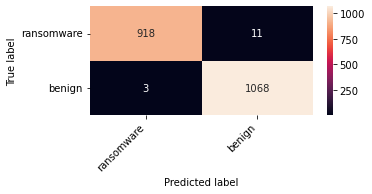

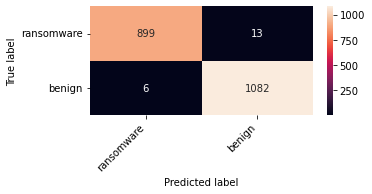

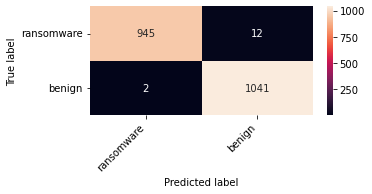

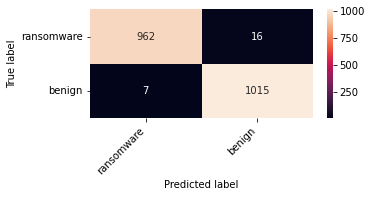

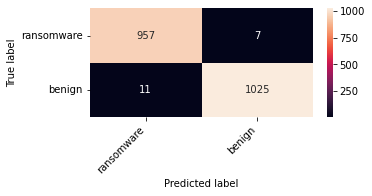

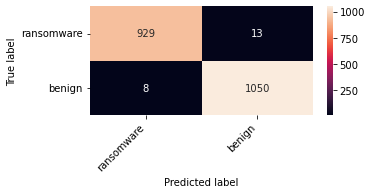

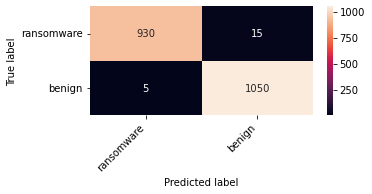

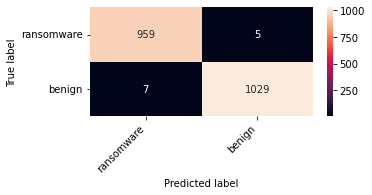

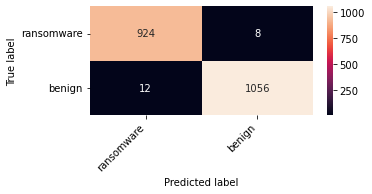

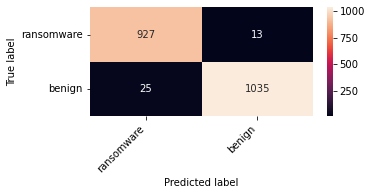

In [19]:
fold_no = 1

for train, test in kfold.split(imgs,labels):
    
    # Build the DenseNet model
    base_model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
    
    # Add the classification layers for this dataset
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(1000, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation = 'softmax')(x)
    
    # Compile the model
    head_model = Model(inputs = base_model.input, outputs = predictions)
    head_model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])
    
    # Freeze all but last eight layers
    for layer in head_model.layers[:-8]:
        layer.trainable=False
    
    for layer in head_model.layers[-8:]:
        layer.trainable=True
    
    
    # Run the CNN
    history.append(
        head_model.fit(
        imgs[train], 
        labels[train], 
        validation_data=(imgs[test], labels[test]), 
        epochs=epoch_t,
        callbacks = [anne, checkpoint]) # The actual computation of the CNN
    )
    
    # Generate generalization metrics
    scores = head_model.evaluate(imgs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {head_model.metrics_names[0]} of {scores[0]}; {head_model.metrics_names[1]} of {scores[1]*100}%')
    multi_acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    # Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
    y_pred = np.append(y_pred, np.argmax(head_model.predict(imgs[test]), axis=-1))
    y_true = np.append(y_true, np.argmax(labels[test], axis=1))
    
    y_pred2 = np.argmax(head_model.predict(imgs[test]), axis=-1)
    y_true2 = np.argmax(labels[test], axis=1)
    
    # Transform predictions to binary: ransomware / benign
    y_predbin = [] 
    y_truebin = []
    for count, value in enumerate(y_true2):
        if y_true2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_truebin.append(0)
        else: y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

        if y_pred2[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
            y_predbin.append(0)
        else: y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
        continue
    
    # Save the binary data distribution
    rw_count.append(len(y_truebin) - np.sum(y_truebin))
    bn_count.append(np.sum(y_truebin))
    
    # Binary confusion Matrix
    c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)
    
    # Plot the confusion matrix
    confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)
    
    # Save the true/false positives/negatives
    tp.append(c_matrix_bin[0,0])
    fp.append(c_matrix_bin[0,1])
    fn.append(c_matrix_bin[1,0])
    tn.append(c_matrix_bin[1,1])
    
    # Save the performance metrics used to compare the models
    multi_f1_per_fold.append(f1_score(y_true2, y_pred2, average='macro'))
    bin_tpr_per_fold.append(c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1])) #True Positive Rate
    bin_acc_per_fold.append(accuracy_score(y_truebin, y_predbin)) # Accuracy
    bin_f1_per_fold.append(f1_score(y_truebin, y_predbin, labels=0)) # F1 Score
    bin_mcc_per_fold.append(matthews_corrcoef(y_truebin, y_predbin))  # Matthews Correlation Coefficient
    
    # Save the multi-class data distribution
    train_distr.append((sum(labels[train])/labels[train].shape[0])*100)
    test_distr.append((sum(labels[test])/labels[test].shape[0])*100)
    

Cross validation run overview

In [20]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(multi_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {multi_acc_per_fold[i]*100}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(multi_acc_per_fold)*100}% (+- {np.std(multi_acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.18617752194404602 - Accuracy: 97.29999899864197%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.21329396963119507 - Accuracy: 96.14999890327454%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.15202480554580688 - Accuracy: 97.04999923706055%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.17181795835494995 - Accuracy: 96.64999842643738%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.15810048580169678 - Accuracy: 95.95000147819519%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.20622238516807556 - Accuracy: 96.10000252723694%
------------------------------------------------------------------

# Evaluating performance

Create data distribution graph

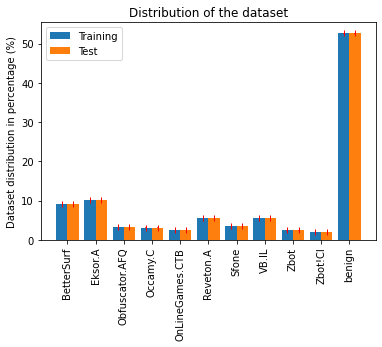

In [21]:
perc_train = np.mean(train_distr, axis = 0)
perc_test =  np.mean(test_distr, axis = 0)

plt.bar(x_axis - 0.2, perc_train, 0.4, label = 'Training')
plt.errorbar(x_axis - 0.2, perc_train, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize = 0)

plt.bar(x_axis + 0.2, perc_test,0.4, label = 'Test')
plt.errorbar(x_axis + 0.2, perc_test, yerr = np.std(train_distr, axis = 0), 
             fmt='|', color='red', capsize=0.0)


plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')
plt.xticks(x_axis, list(classes), rotation='vertical')
plt.legend()

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [22]:
t = PrettyTable(['Metric', 'Performance', 'St.Deviation'])
t.add_row(['M-Class', "", ""])
t.add_row(['Acc    ', round(np.mean(multi_acc_per_fold),4), round(np.std(multi_acc_per_fold),4)])
t.add_row(['Loss   ', round(np.mean(loss_per_fold),4), round(np.std(loss_per_fold),4)])
t.add_row(['Macro F1', round(np.mean(multi_f1_per_fold), 4), round(np.std(multi_f1_per_fold),4)])
t.border = True
t.add_row(['', '', ''])
t.add_row(['B-Class', "", ""])
t.add_row(['TPR    ', round(np.mean(bin_tpr_per_fold),4), round(np.std(bin_tpr_per_fold),4)])
t.add_row(['Acc    ', round(np.mean(bin_acc_per_fold),4), round(np.std(bin_acc_per_fold),4)])
t.add_row(['F1     ', round(np.mean(bin_f1_per_fold),4), round(np.std(bin_f1_per_fold),4)])
t.add_row(['MCC    ', round(np.mean(bin_mcc_per_fold),4), round(np.std(bin_mcc_per_fold),4)])
t.header = True
t.set_style(MSWORD_FRIENDLY)
t.align = "l"
t.title = "Performance of DenseNet169"
print(t)

+---------------------------------------+
|       Performance of DenseNet169      |
| Metric   | Performance | St.Deviation |
| M-Class  |             |              |
| Acc      | 0.9611      | 0.0068       |
| Loss     | 0.1936      | 0.0295       |
| Macro F1 | 0.8998      | 0.0141       |
|          |             |              |
| B-Class  |             |              |
| TPR      | 0.988       | 0.0036       |
| Acc      | 0.99        | 0.0034       |
| F1       | 0.9906      | 0.0033       |
| MCC      | 0.9801      | 0.0069       |


In [23]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

Evaluate the model based on the test set

Save a table with the performance on the test set

**Evaluating overfitting and other model performance measures**

In [24]:
linecolours = ['gray', 'orange', 'blue', 'green','silver', 'cyan', 'red', 'purple', 'lightgreen', 'black', 'brown']

In [25]:
def eval_metric(model, history, metric_name, ymin, ymax):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    for i in range(n_folds-1):  
        metric = history[i].history[metric_name]
        val_metric = history[i].history['val_' + metric_name]
        e = range(1, epoch_t + 1)
        plt.plot(e, metric, marker = 'o', linestyle = 'none', color = linecolours[i])
        plt.plot(e, val_metric, color = linecolours[i])
        
    metric = history[n_folds-1].history[metric_name]
    val_metric = history[n_folds-1].history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, marker = 'o', linestyle = 'none', label = 'Training', color = linecolours[n_folds-1])
    plt.plot(e, val_metric, label = 'Validation', color = linecolours[n_folds-1])
    
    plt.ylim(ymin, ymax)
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for DenseNet169 across folds')
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

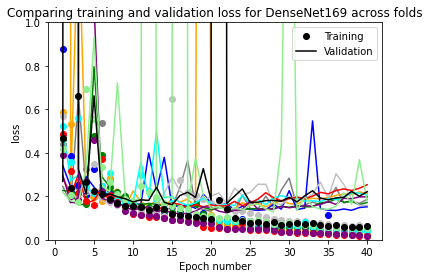

In [26]:
eval_metric(head_model, history, 'loss', 0,1)

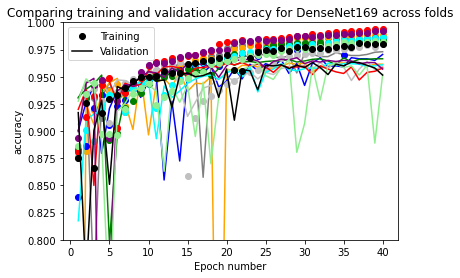

In [27]:
eval_metric(head_model, history, 'accuracy', 0.8,1)

# Confusion Matrix
Analysing the results

# Binary classification
y_predbin and y_testbin are the binary classification arrays. 0 = ransomware and 1 = benign

Plot the distribution of dataset as ransomware - benign

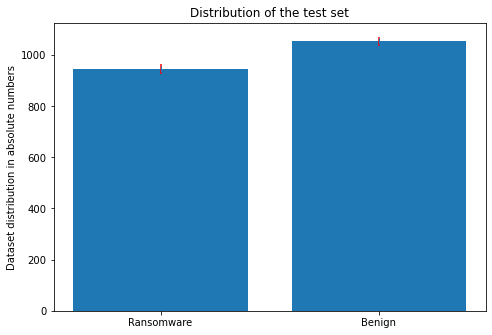

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [np.mean(rw_count), np.mean(bn_count)]
plt.title('Distribution of the test set')
plt.ylabel('Dataset distribution in absolute numbers')
ax.bar(x_lab, y_lab)
ax.errorbar(x_lab, y_lab, yerr = [np.std(rw_count), np.std(bn_count)], fmt = '|', ecolor='red')
if cenv == 0:
    plt.savefig("bin_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

Plot binary confusion matrix

In [29]:
all_y_predbin = [] 
all_y_truebin = []
for count, value in enumerate(y_true):
    if y_true[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_truebin.append(0)
    else: all_y_truebin.append(1) # if prediction is not one of the ransomware families, then it is benign

    if y_pred[count] in range(10): # range(10) is 0 to 9, meaning all ransomware families
        all_y_predbin.append(0)
    else: all_y_predbin.append(1) # if prediction is not one of the ransomware families, then it is benign
    continue

In [30]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, name, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"{(name.capitalize())} Confusion Matrix - DenseNet169")
    if cenv == 0:
        plt.savefig(f"{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/{name}_cmatrix.png", bbox_inches = 'tight', dpi = 150)

In [31]:
c_matrix_bin = metrics.confusion_matrix(all_y_truebin, all_y_predbin)

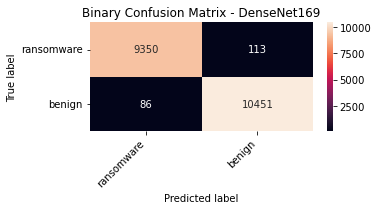

In [32]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, 'binary', figsize = (5,2), fontsize=10)

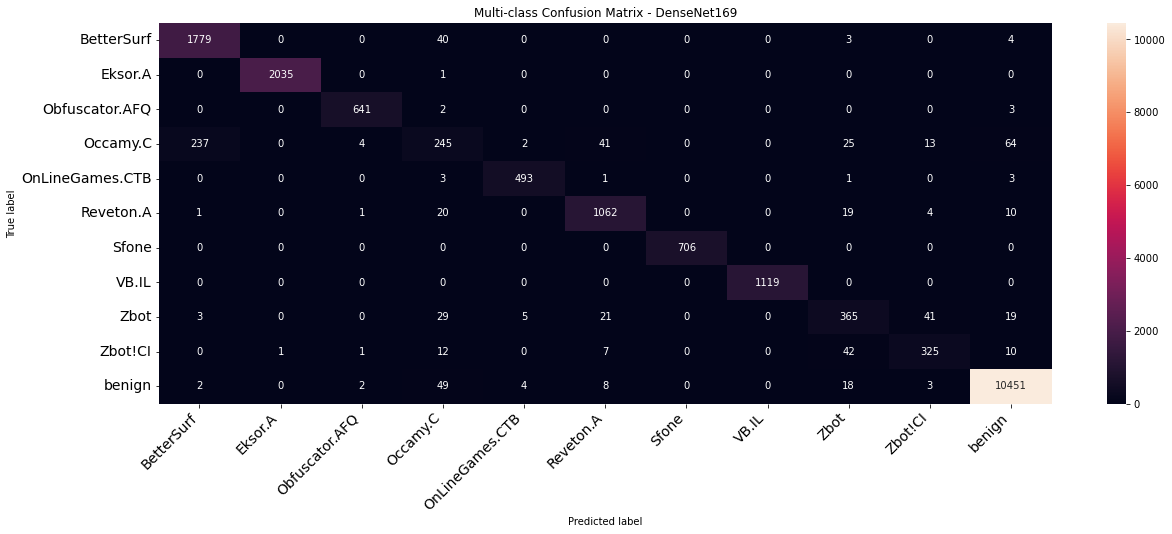

In [33]:
c_matrix = metrics.confusion_matrix(y_true, y_pred)
class_names= batches.class_indices.keys()
confusion_matrix_bin(c_matrix, class_names, 'multi-class', figsize = (20,7), fontsize=14)